In [1]:
import os
import sys

PROJECT_ROOT = os.path.join(os.path.abspath(os.path.dirname('./../../')), 'src')

sys.path.append(PROJECT_ROOT)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from config import Config
from feature_extraction_utils import *
from matplotlib import pyplot as plt
import tqdm
import seaborn as sns

**Load data**

In [3]:
%%time
cfg = Config()
ds = DataSource(cfg)
ds.read_data()
ds.validation_split()

Reading groups_desc...
Reading train_x...
Reading test_x...
Reading train_target...
Reading test_target...
Validation split: by clientID
CPU times: user 25.5 s, sys: 5.4 s, total: 30.9 s
Wall time: 23.9 s


In [4]:
cfg['data_source'].keys()

dict_keys(['groups_desc', 'train_x', 'test_x', 'train_target', 'test_target'])

In [5]:
print(ds)

Dataset: groups_desc, shape: (204, 2)
Dataset: train_x, shape: (21295142, 4)
Dataset: test_x, shape: (17667328, 4)
Dataset: train_target, shape: (24145, 2)
Dataset: test_target, shape: (20000, 1)
Dataset: valid_x, shape: (5155435, 4)
Dataset: valid_target, shape: (5855, 2)


# Features playground

**Extract global features**

In [6]:
extractor = GlobalClientFeaturesExtractor()

for dataset in ['train', 'valid']:
    transactions_df = ds.get_data(f'{dataset}_x')
    target_df = ds.get_data(f'{dataset}_target')
    path = adjust_path(cfg._cfg['global_features'][f'{dataset}_set'])
    if os.path.exists(path):
        print(f'Global features for {dataset} dataset have been calculated already')
    else:
        print(f'Calculating global features for {dataset} dataset...')
        extractor.extract_from_dataset(transactions_df, target_df, path)
    ds.add_features(f'{dataset}_gf', path)

Global features for train dataset have been calculated already
Global features for valid dataset have been calculated already


In [7]:
print(ds)

Dataset: groups_desc, shape: (204, 2)
Dataset: train_x, shape: (21295142, 4)
Dataset: test_x, shape: (17667328, 4)
Dataset: train_target, shape: (24145, 2)
Dataset: test_target, shape: (20000, 1)
Dataset: valid_x, shape: (5155435, 4)
Dataset: valid_target, shape: (5855, 2)
Dataset: train_gf, shape: (24145, 708)
Dataset: valid_gf, shape: (5855, 708)


**Global features PCA**

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

data = ds.get_data('train_gf')
labels = ds.get_data('train_target')
pca_output = PCA(n_components=2).fit_transform(MinMaxScaler().fit_transform(data))

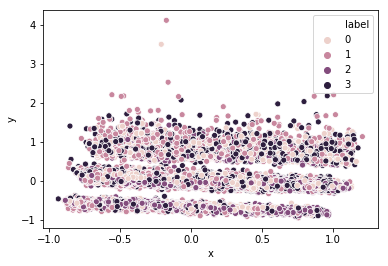

In [9]:
pca_df = pd.DataFrame({'x': pca_output[:, 0], 'y': pca_output[:, 1], 'label': labels.bins})

sns.scatterplot(data=pca_df, x='x', y='y', hue='label');

# Trans2Vec

**Extract time-series features**

In [10]:
extractor = TimeSeriesFeatureExtractor()

#client_ids = list(train_x.sample(10).client_id.values)

for dataset in ['train', 'valid']:
    transactions_df = ds.get_data(f'{dataset}_x')#.query(f'client_id == {client_ids}')
    target_df = ds.get_data(f'{dataset}_target')#.query(f'client_id == {client_ids}')
    path_dict = {k: adjust_path(v)
                 for k, v in cfg._cfg['ts_features'][f'{dataset}_set'].items()}
    if os.path.exists(list(path_dict.values())[0]):
        print(f'TS features for {dataset} dataset have been calculated already')
    else:
        print(f'Calculating TS features for {dataset} dataset...')
        extractor.extract_from_dataset(transactions_df, target_df, path_dict)
    for k, path in path_dict.items():
        ds.add_features(f'{dataset}_{k}', path)

TS features for train dataset have been calculated already
TS features for valid dataset have been calculated already


In [11]:
print(ds)

Dataset: groups_desc, shape: (204, 2)
Dataset: train_x, shape: (21295142, 4)
Dataset: test_x, shape: (17667328, 4)
Dataset: train_target, shape: (24145, 2)
Dataset: test_target, shape: (20000, 1)
Dataset: valid_x, shape: (5155435, 4)
Dataset: valid_target, shape: (5855, 2)
Dataset: train_gf, shape: (24145, 708)
Dataset: valid_gf, shape: (5855, 708)
Dataset: train_small_group_seq, shape: (24145, 730)
Dataset: train_money_seq, shape: (24145, 730)
Dataset: valid_small_group_seq, shape: (5855, 730)
Dataset: valid_money_seq, shape: (5855, 730)
